# Zeitdiskrete Analyse: Approximation von kontinuierlichen Verteilungen
Mit der zeitdiskreten Analyse von G/G/1 Wartesystemen kann die Verteilungsfunktion der Wartezeit numerisch bestimmt werden. Beliebige kontinuierliche Verteilungen können dabei durch diskrete Verteilungen approximiert werden. 
Am Beispiel des M/G/1 Wartesystems wird die exakte Wartezeit (mittels Laplace Transformation) mit den Ergebnissen der zeitdiskreten Analyse verglichen. Je feiner die Diskretisierung $\Delta t$, desto genauer ist die zeitdiskrete Analyse. Mit diesem Parameter soll im Notebook herumgespielt werden, um zu sehen, wie sich das auf die Genauigkeit der numerischen Ergebnisse auswirkt.

Der Ankunftsprozess ist ein Poisson-Prozess mit Rate $\lambda=1/E[A]$. Die Bedienzeit folgt einer Erlang-k Verteilung, $B \sim Er(k,\mu_i)$ mit $E[B]=1/\mu$. Jede einzelne der $k$ Phasen der Erlang-k Verteilung folgt dabei einer exponentiellen Verteilung mit Rate $\mu_i = k \mu = k / E[B]$.

## Definition der Parameter 
Die Zwischenankunftszeit $A$ und die Bedienzeit $B$ werden spezifiziert. Neben den Parametern der Verteilungen wird auch die Laplace Transformierte der Bedienzeit `LT_B(s)` angegeben.

In [24]:
from matplotlib import pyplot as plt
import numpy as np
from mpmath import *
import scipy.stats 

#%% Diskretisierung
deltaT = 0.5

# Zwischenankunftszeit A ~ Exp(lam)
lam = 0.7   # Ankunftsrate
EA = 1/lam  # Erwartungswert der Zwischenankunftszeit
cA = 1      # Poisson Prozess: Variationskoeffizient

# PDF von A
def at(t, lam=lam):
    return lam*np.exp(-lam*t)

# CDF von A
def At(t, lam=lam):
    return 1-np.exp(-lam*t)

# Bedienzeit B ~ Er_k
EB = 1     # Erwartungswert der Bedienzeit
mu = 1/EB  # Bedienrate
k = 3      # k Phasen der Erlang-k Verteilung
cB = 1/np.sqrt(k) # Variationskoeffizient der Erlang-k Verteilung

# Auslastung: Die Auslastung muss kleiner 100% sein.
rho =lam/mu

# Laplace Transformierte der Bedienzeit B ~ Er_k
def LT_B(s, EB=EB, n=k):     
    return 1/(1+s*EB/n)**n # Erlang k

# Service Time B: CDF
def Bt(t, EB=EB, n=k):
    #return 1-np.exp(-t/EB) # M/M/1
    rvB = scipy.stats.erlang(n,scale=EB/n)
    return rvB.cdf(t)

# Beschriftung der Plots
title = f'M/M/1 with $\lambda={lam}, E[B]={EB}$' if k==1 else f'M/Er/1 with $\lambda={lam}, E[B]={EB}, cB={cB:.2f}$'

## Laplace Transformierte der Wartezeit
Für ein M/G/1 System ist die Laplace Transformierte der Wartezeit wie folgt. Zur Berechnung wird die Laplace Transformierte der Bedienzeit benötigt, $LT\{b(t)\}=\Phi_B(s)$.
$$ LT\{w(t)\} = \Phi_W(s) = \frac{(1-\rho)\cdot s}{s-\lambda+\lambda \Phi_B(s)}$$


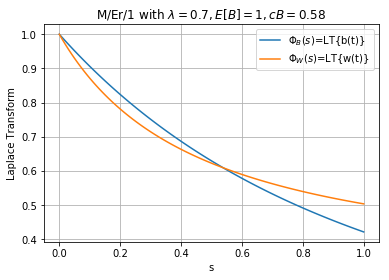

In [25]:
# Laplace Transform of Waiting Time
def LT_W(s, lam=lam, EB=EB):
    rho = EB*lam
    return (1-rho)*s/(s-lam+lam*LT_B(s, EB))

s = np.linspace(0.00001,1,100)
plt.plot(s, LT_B(s), label='$\Phi_B(s)$=LT{b(t)}')
plt.plot(s, LT_W(s), label='$\Phi_W(s)$=LT{w(t)}')
plt.xlabel('s')    
plt.ylabel('Laplace Transform')
plt.legend()
plt.grid()
plt.title(title);

## Numerische Wartezeitverteilung: Inverse numerische Laplace Transformation
Die inverse numerische Laplace Transformation liefert die Verteilungsdichtefunktion (PFD) der Wartezeit aus $LT\{w(t)\} = \Phi_W(s)$.
$$w(t) = LT^{-1}\{\Phi_W(s)\}$$

Zur Berechnung der Verteilungsfunktion (CDF) wird die inverse Laplace Transformation von $\Phi_W(s)/s$ berechnet.
$$W(t) = LT^{-1}\{\frac{\Phi_W(s)}{s}\}$$

Dazu kann in Python das Package `mpmath` genutzt werden. Die Funktion heisst [invertlaplace](http://mpmath.org/doc/current/calculus/inverselaplace.html).


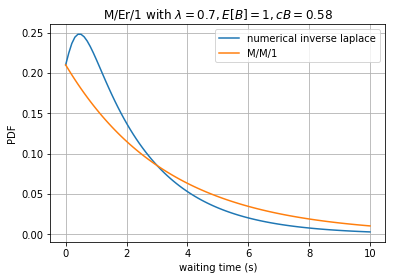

In [26]:
# PDF der Wartezeit: w(t) (Inverse numerical Laplace Transform)
w = lambda t: invertlaplace(LT_W, t ,method='talbot')

# CDF der Wartezeit mittels LT{W(t)} = LT{w(t)}/s
W = lambda t: invertlaplace(lambda s: LT_W(s)/s, t, method='talbot')

# Vergleich der Ergebnisse mit einem M/M/1 System
def wmm1(t, lam=lam, EB=EB):
    mu = 1/EB
    rho = lam/mu
    return mu*(1-rho)*rho*np.exp(-mu*(1-rho)*t)

t_lt = np.linspace(1e-9,10,100)
wt = np.array([w(ti) for ti in t_lt])
plt.plot(t_lt, wt, label='numerical inverse laplace')
plt.plot(t_lt, wmm1(t_lt), label='M/M/1')
plt.xlabel('waiting time (s)')
plt.ylabel('PDF')
plt.legend()
plt.grid()
plt.title(title);

## Diskretisierung der Zwischenankunftszeit und Bedienzeit
Die Wahrscheinlichkeit $P(A\leq t)=A(t)$ wird an den diskreten Stellen $i \Delta t$ für $i=0,1,..., a_\max$ berechnet. Dann ist die diskrete Verteilung $A_d$ spezifiziert durch die Wahrscheinlichkeiten $$a_d(i)=P(A_d=i)=A(i\cdot \Delta t)-A((i-1)\cdot \Delta t)$$ für $0 < i < a_\max$.
Es is $a_d(0)=0$ und $a_d(a_\max) = 1-A\left((a_\max-1)\cdot \Delta t\right)$.

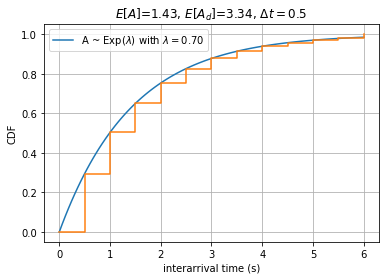

In [28]:
#%% Zwischenankunftszeit
t = np.linspace(0,6,100)
plt.plot(t, At(t), label=f'A ~ Exp($\lambda$) with $\lambda={lam:.2f}$')
plt.xlabel('interarrival time (s)')
plt.ylabel('CDF')
plt.legend()
plt.grid()
plt.title(title)

# compute discretized interarrival times
amax = int(t[-1]/deltaT) 
tdisc = np.arange(0, amax+1)*deltaT
A = At(tdisc)
A[-1] = 1
plt.step(tdisc,A, where='post')

# compute probabilities 
a = np.insert(np.diff(A), 0, 0)
xa = np.arange(0, amax+1).astype(int)
EAdisc = np.matmul(a,xa)
plt.title(f'$E[A]$={EA:.2f}, $E[A_d]$={EAdisc:.2f}, $\Delta t={deltaT}$')

#%% Bedienzeit Diskretisierung
B = Bt(tdisc, EB=EB)
B[-1] = 1
b = np.insert(np.diff(B), 0, 0)
xb = xa

## Diskrete Verteilung von A und B

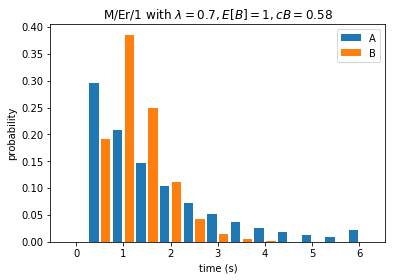

In [29]:
plt.bar(xa*deltaT-deltaT/4, a, width=deltaT/2.5, label='A')
plt.bar(xb*deltaT+deltaT/4, b, width=deltaT/2.5, label='B')
plt.xlabel('time (s)')
plt.ylabel('probability')
plt.legend()
plt.title(title);

## Charakteristische Systemfunktion
Die charakteristische Systemfunktion ist die Differenz $C=B-A$. Die Verteilung wird durch Faltung berechnet.
$$ c(k)=b(k)*a(-k)$$

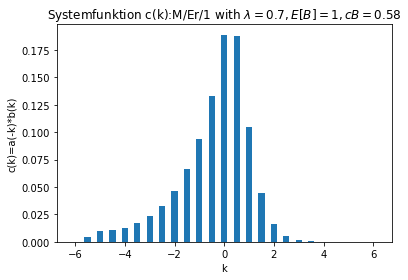

In [30]:
#%% Systemfunktion: c(k) = a(-k)*b(k)
xaminus = -xa[::-1]
aminus = a[::-1]

c = np.convolve(aminus,b)
xc = np.arange(xaminus[0], xb[-1]+1)

plt.figure(5)
plt.clf()
plt.bar(xc*deltaT,c, width=deltaT/2)
#plt.xlim([-8,8])
plt.xlabel('k')
plt.ylabel('c(k)=a(-k)*b(k)')
plt.title('Systemfunktion c(k):'+title);

## Zeitdiskrete Analyse des G/G/1 Wartesystems
Zur iterativen Berechnung der Wartezeiten des G/G/1 Wartesystems wird noch der $\pi_0$-Operator benötigt. Die stationären Wartewahrscheinlichkeiten werden mit Hilfe eines Abbruchkriteriums bestimmt. Hier wird dazu die Differenz des Erwartungswertes der Wartezeit in den Iterationsschritten verglichen, bis ein Schwellwert $\epsilon$ unterschritten ist.

Der Erwartungswert der Wartezeit $E[W_{disc}]$ mit der zeitdiskreten Analyse wird verglichen mit dem exakten Wert $E[W]$ (für M/G/1 Wartesysteme). Zusätzlich werden noch die Approximationen von Kingman für den Erwartungswert bzw. eine obere Schranke für den Erwartungswert angegeben.

In [31]:
#%% Pi-Operator
def pi0(x,p):
    prob = np.zeros(len(np.where(x>0)[0])+1)
    prob[1:] = p[np.where(x>0)]
    prob[0] = p[np.where(x<=0)].sum()
    x0 = x[np.where(x>=0)]
    
    return prob, x0

#%% Initialisierung der Wartezeit: W_0(0)=1
wnx = [0] # Wartezeiten
wnp = [1]  # initialisiere: W(0)=1
#plt.plot(wnx,wnp,'o')
EWnold = float("inf")
EW = np.matmul(wnx,wnp)
n = 0

#%% Wartezeitverteilung iterativ berechnen
while abs(EWnold-EW)>0.00001:
    n += 1    
    wn_c_x = np.arange(xc[0]+wnx[0], wnx[-1]+xc[-1]+1)
    wn_c_p = np.convolve(wnp, c)
    wnp, wnx = pi0(wn_c_x, wn_c_p)
    EWnold = EW
    EW = np.matmul(wnx*deltaT,wnp)
print(f'Nach {n} Iterationsschritten ist |E[W_{n+1}]-E[W_n]| = {abs(EWnold-EW)}')
    
#%% Kingman
Kingman = rho/(1-rho)*(cA**2+cB**2)/2*EB
Upper = EA*(cA**2+rho**2*cB**2)/2/(1-rho)
print(f'E[W]={EW:.4f} (exakt)')
print(f'E[W_approx]={Kingman:.4f}, upper bound {Upper:.4f} (Kingman)')
print(f'E[W_disc]={EW:.4f} (zeitdiskrete Analyse)')

Nach 125 Iterationsschritten ist |E[W_126]-E[W_n]| = 9.524238078872926e-06
E[W]=1.4589 (exakt)
E[W_approx]=1.5556, upper bound 2.7698 (Kingman)
E[W_disc]=1.4589 (zeitdiskrete Analyse)


## Vergleich der Ergebnisse: Zeitdiskrete Analyse vs. M/G/1
Die Verteilungsfunktion der Wartezeit (durch die zeitdiskrete Analyse und Diskretisierung der Verteilungen) wird nun verglichen mit der exakten Lösung (M/G/1 und Laplace Transformation). Zusätzlich wird die Wartezeit des M/M/1 Systems gegenüber gestellt. Für geringere Werte von $\Delta t$ werden die Ergebnisse auf Kosten höheren Berechnungsaufwandes genauer.

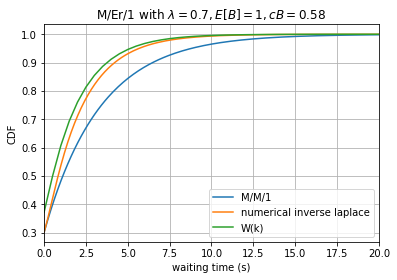

In [32]:
# Exact solution for M/M/1: CDF
def Wmm1(t, lam=lam, EB=EB):
    mu = 1/EB
    rho = lam/mu
    return 1-rho*np.exp(-mu*(1-rho)*t)

t = np.linspace(0.01,20,200)
plt.plot(t, Wmm1(t), label='M/M/1')
Wt = np.array([W(ti) for ti in t])
plt.plot(t, Wt, label='numerical inverse laplace')
plt.xlabel('waiting time (s)')
plt.ylabel('CDF')
plt.grid()
plt.plot(wnx*deltaT,wnp.cumsum(), label='W(k)')    
plt.legend()
plt.xlim([0, 20])     
plt.title(title);